In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# **Preparing Data**

**Load the datasets**

In [ ]:
weather_df = pd.read_excel('/content/drive/MyDrive/CS/weather_features.xlsx')
energy_df = pd.read_excel('/content/drive/MyDrive/CS/energy_dataset.xlsx')

In [ ]:
energy_df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17,NaN,6436,26118,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16,NaN,5856,24934,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8,NaN,5454,23515,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2,NaN,5151,22642,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9,NaN,4861,21785,20264.0,38.41,56.04


In [ ]:
weather_df.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


**Drop the city_name column**

In [ ]:
weather_df =  weather_df.drop(columns=['city_name'])

In [ ]:
aggregated_df = weather_df.groupby('dt_iso').agg({
    'temp' : 'mean',
    'temp_min' 	: 'mean',
    'temp_max'	: 'mean',
    'pressure'	: 'mean',
    'humidity'	: 'mean',
    'wind_speed' :	'mean',
    'wind_deg'	: 'mean',
    'rain_1h'	: 'mean',
    'rain_3h'	: 'mean',
    'snow_3h'	: 'mean',
    'clouds_all' :	'mean',
    'weather_id'	: lambda x: x.mode()[0],
    'weather_main' :	lambda x: x.mode()[0],
    'weather_description' : lambda x: x.mode()[0],
    'weather_icon' : lambda x: x.mode()[0],
    }
).reset_index()

<ipython-input-8-94d930f62d4e>:16: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  'weather_icon' : lambda x: x.mode()[0],
<ipython-input-8-94d930f62d4e>:16: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  'weather_icon' : lambda x: x.mode()[0],


In [ ]:
aggregated_df.head()

,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n


**Convert the date columns to datetime format**

In [ ]:
aggregated_df['dt_iso'] = pd.to_datetime(aggregated_df['dt_iso'], utc=True)
energy_df['time'] = pd.to_datetime(energy_df['time'], utc=True)

**Merge the datasets on the common datetime column**

In [ ]:
merged_df = pd.merge(energy_df, aggregated_df, left_on='time', right_on='dt_iso')

**Drop the extra 'dt_iso' column after merging**

In [ ]:
merged_df =  merged_df.drop(columns=['dt_iso'])

In [ ]:
merged_df.shape

(35064, 44)

# **Exploratary Data Analysis**

In [ ]:
merged_df.select_dtypes(include=['number']).sum()

generation biomass                             1.344023e+07
generation fossil brown coal/lignite           1.570268e+07
generation fossil coal-derived gas             0.000000e+00
generation fossil gas                          1.970545e+08
generation fossil hard coal                    1.491581e+08
generation fossil oil                          1.045462e+07
generation fossil oil shale                    0.000000e+00
generation fossil peat                         0.000000e+00
generation geothermal                          0.000000e+00
generation hydro pumped storage aggregated     0.000000e+00
generation hydro pumped storage consumption    1.666661e+07
generation hydro run-of-river and poundage     3.406781e+07
generation hydro water reservoir               9.129885e+07
generation marine                              0.000000e+00
generation nuclear                             2.195312e+08
generation other                               2.110771e+06
generation other renewable              

**Drop the column which have only zero value**

In [ ]:
merged_df =  merged_df.drop(columns=['generation fossil coal-derived gas',
                                       'generation fossil oil shale',
                                       'generation fossil peat',
                                       'generation geothermal',
                                       'generation hydro pumped storage aggregated',
                                       'generation marine',
                                       'generation wind offshore',
                                       'forecast wind offshore eday ahead'])

In [ ]:
merged_df.isnull().sum()

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0


**Applying forward and backward fill to treat the missing values**

In [ ]:
merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)
merged_df.isnull().sum()

time                                           0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual        

In [ ]:
merged_df.head(10)


,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,2.0,135.2,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,2.0,135.8,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,2.4,119.0,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,2.4,119.2,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,2.4,118.4,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
5,2015-01-01 04:00:00+00:00,410.0,178.0,4038.0,3590.0,156.0,2109.0,952.0,743.0,7098.0,...,2.4,174.8,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
6,2015-01-01 05:00:00+00:00,401.0,172.0,4040.0,3368.0,158.0,2108.0,961.0,848.0,7098.0,...,2.4,174.4,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
7,2015-01-01 06:00:00+00:00,408.0,172.0,4030.0,3208.0,160.0,2031.0,983.0,1012.0,7099.0,...,2.4,174.4,0.0,0.0,0.0,0.0,800,clear,sky is clear,01n
8,2015-01-01 07:00:00+00:00,413.0,177.0,4052.0,3335.0,161.0,2119.0,1001.0,1015.0,7098.0,...,1.4,248.0,0.0,0.0,0.0,0.0,800,clear,sky is clear,01d
9,2015-01-01 08:00:00+00:00,419.0,177.0,4137.0,3437.0,163.0,2170.0,1041.0,1357.0,7097.0,...,1.4,247.8,0.0,0.0,0.0,0.0,800,clear,sky is clear,01d


In [ ]:
merged_df.shape

(35064, 36)

**Convert the datetime column to string as excel does not support datetimes**

In [ ]:
merged_df['time'] = merged_df['time'].astype(str)

**Save the merged dataframe to a new Excel file**

In [ ]:
output_path = '/content/drive/MyDrive/CS/merged_energy_weather.xlsx'
merged_df.to_excel(output_path, index=False)

# **Feature Engineering**

**Identify outliers using the IQR method**

In [ ]:
def identify_outliers_df(df):
    outliers = pd.DataFrame()
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = (df[column] < lower_bound) | (df[column] > upper_bound)
    return outliers

In [ ]:
# Identify outliers in the merged DataFrame
outliers_df = identify_outliers_df(merged_df)

In [ ]:
outliers_df

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35060,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35061,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35062,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Treat outliers by capping them at the lower and upper bounds for the entire DataFrame**

In [ ]:
def treat_outliers_df(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

In [ ]:
# Treat outliers in the merged DataFrame
treat_outliers_df(merged_df)

In [ ]:
outliers_df = identify_outliers_df(merged_df)

In [ ]:
outliers_df

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35060,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35061,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35062,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Extract new features from the datetime column**

In [ ]:
merged_df['time'] = pd.to_datetime(merged_df['time'], utc=True)

merged_df['hour'] = merged_df['time'].dt.hour
merged_df['day'] = merged_df['time'].dt.day
merged_df['month'] = merged_df['time'].dt.month
merged_df['day_of_week'] = merged_df['time'].dt.dayofweek

**Create binary columns for each month from January to December**

In [ ]:
for month in range(1, 13):
    merged_df[f'month_{month}'] = (merged_df['month'] == month).astype(int)

# merged_df['month'] == month creates a boolean series where the value is True if the month column matches the current month in the loop, and False otherwise.
# .astype(int) converts the boolean series to integers, resulting in 1 for True and 0 for False.

**Drop the original month column as it's no longer needed**

In [ ]:
merged_df.drop(columns=['month'], inplace=True)

**Save the dataframe to a new Excel file after processing data**

In [69]:
merged_df['time'] = merged_df['time'].astype(str)

output_path = '/content/drive/MyDrive/CS/merged_energy_weather_final.xlsx'
merged_df.to_excel(output_path, index=False)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 51 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35064 non-null  float64            
 2   generation fossil brown coal/lignite         35064 non-null  float64            
 3   generation fossil gas                        35064 non-null  float64            
 4   generation fossil hard coal                  35064 non-null  float64            
 5   generation fossil oil                        35064 non-null  float64            
 6   generation hydro pumped storage consumption  35064 non-null  float64            
 7   generation hydro run-of-river and poundage   35064 non-null  float64            
 8   generation hydro water res

# **Visualization**

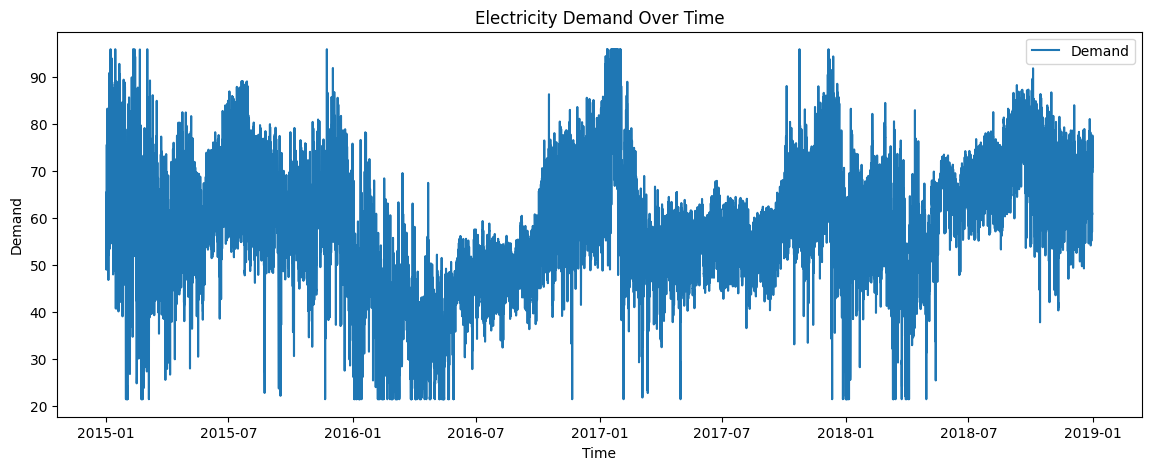

In [ ]:
# Line Plot of Electricity Demand Over Time
plt.figure(figsize=(14, 5))
plt.plot(merged_df['time'], merged_df['price actual'], label='Demand')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Electricity Demand Over Time')
plt.legend()
plt.show()

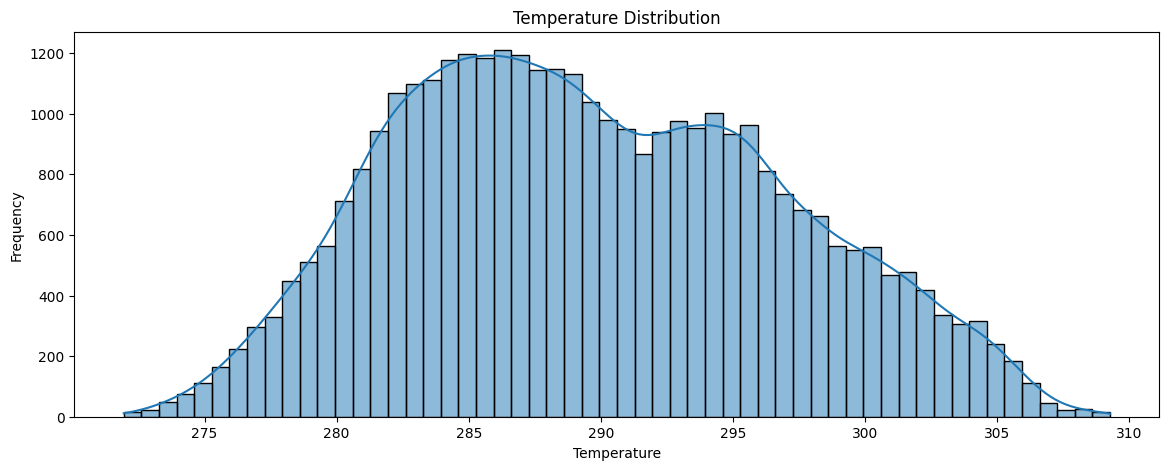

In [ ]:
# Histogram of Temperature Distribution
plt.figure(figsize=(14, 5))
sns.histplot(merged_df['temp'], kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


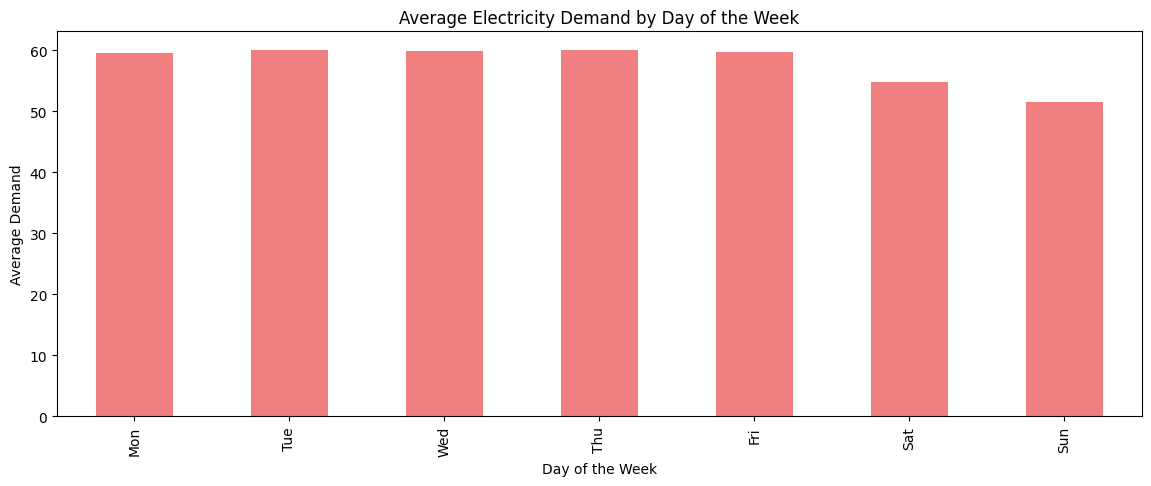

In [ ]:
#Average electricity demand by day of the week
plt.figure(figsize=(14, 5))
avg_demand_by_day = merged_df.groupby('day_of_week')['price actual'].mean()
avg_demand_by_day.plot(kind='bar', color='lightcoral')
plt.title('Average Electricity Demand by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Demand')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

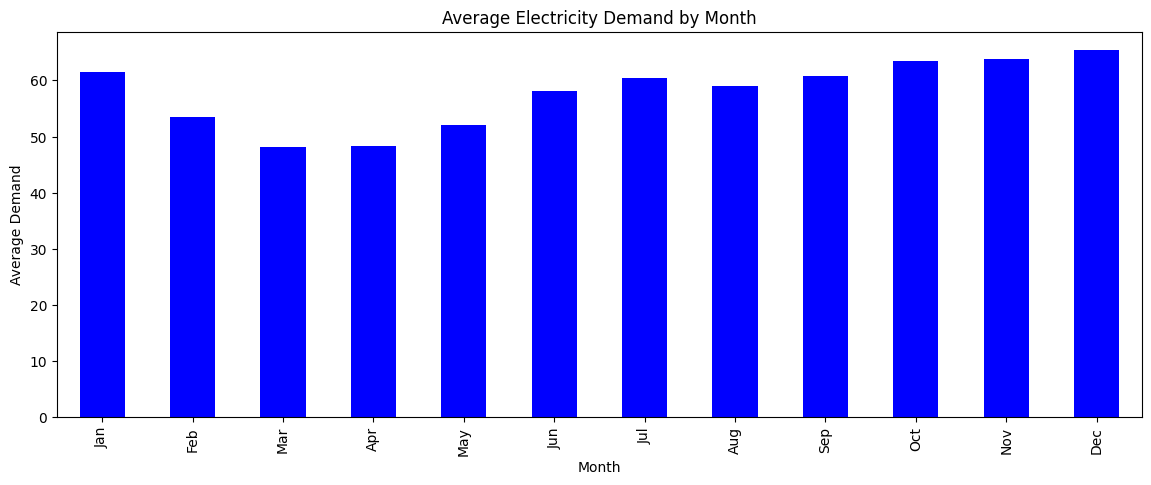

In [ ]:
# Bar Chart Comparing Electricity Demand by Month
monthly_demand = merged_df.groupby(merged_df['time'].dt.month)['price actual'].mean()
plt.figure(figsize=(14, 5))
monthly_demand.plot(kind='bar', color='blue')
plt.title('Average Electricity Demand by Month')
plt.xlabel('Month')
plt.ylabel('Average Demand')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

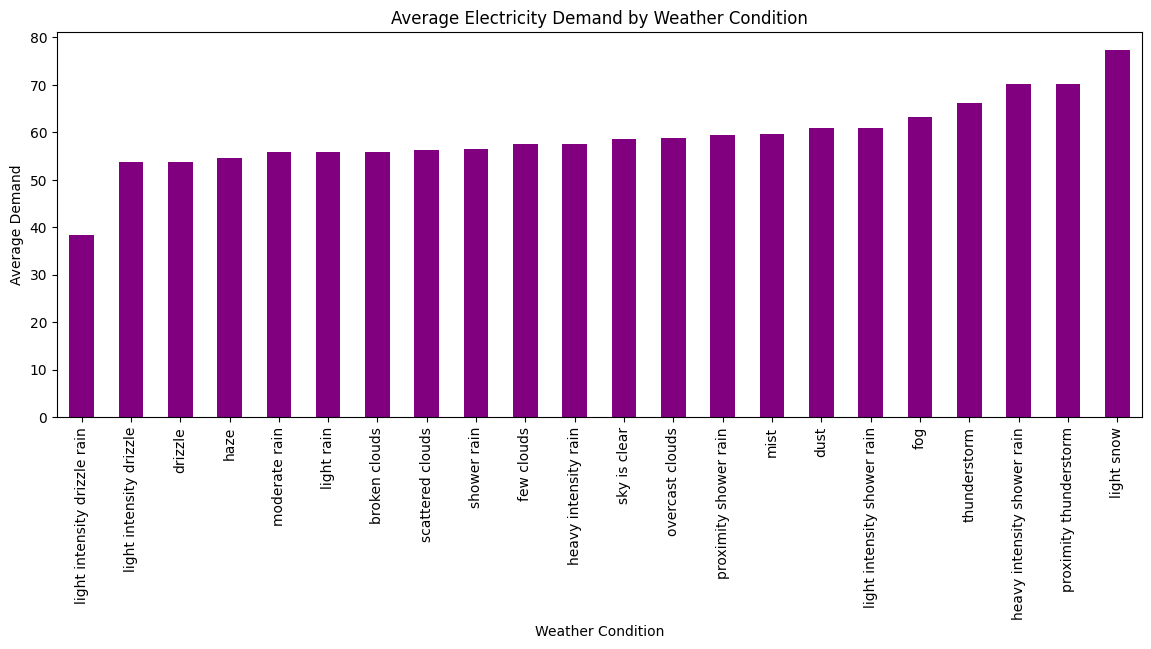

In [ ]:
#Average electricity demand by weather condition
plt.figure(figsize=(14, 5))
avg_demand_by_weather = merged_df.groupby('weather_description')['price actual'].mean().sort_values()
avg_demand_by_weather.plot(kind='bar', color='purple')
plt.title('Average Electricity Demand by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Demand')
plt.xticks(rotation=90)
plt.show()

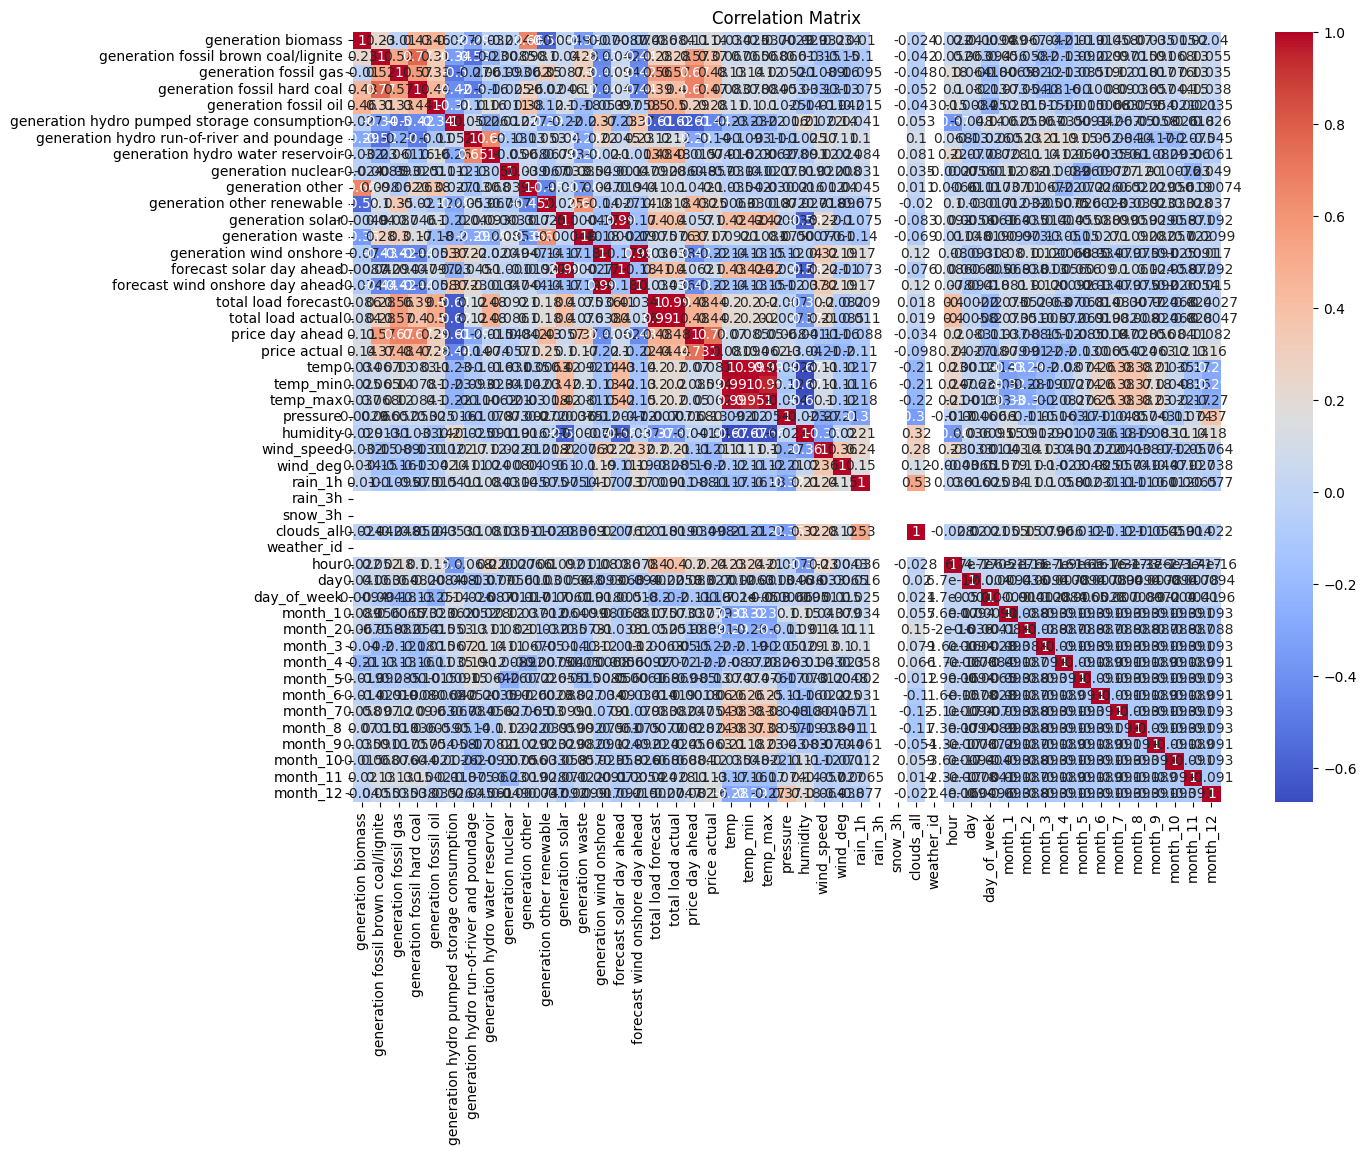

In [68]:
# Drop the original datetime column before calculating the correlation matrix
merged_df_numeric = merged_df.select_dtypes(include=[np.number])

# Correlation matrix
corr_matrix = merged_df_numeric.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()